In [98]:
import requests
import pandas as pd
import time
from datetime import datetime, timezone, timedelta
from pprint import pprint
import os
import zipfile
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import levene, ttest_ind

### Binance API

In [ ]:
def get_binance_funding_rate(symbol, start_time, end_time):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    df_list = []

    while start_time < end_time:
        params = {
            "symbol": symbol,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000
        }

        resp = requests.get(url, params = params)
        data = resp.json()

        if not data:
            break

        df = pd.DataFrame(data)
        df_list.append(df)

        last_time = int(data[-1]["fundingTime"])
        start_time = last_time + 1
        time.sleep(0.3)

    if df_list:
        df_all = pd.concat(df_list, ignore_index = True)
        df_all["fundingTime"] = pd.to_datetime(df_all["fundingTime"], unit = "ms").dt.strftime("%Y-%m-%d %H:%M:%S")
        df_all.set_index("fundingTime", inplace = True)
        df_all["fundingRate"] = pd.to_numeric(df_all["fundingRate"])
        return df_all

    return pd.DataFrame()

In [15]:
symbol = "MINAUSDT"
start = int(datetime(2020, 1, 1).timestamp() * 1000)
end = int(datetime.now().timestamp() * 1000)

df_funding = get_binance_funding_rate(symbol, start, end)

df_funding.to_csv("./funding rate/Binance_funding_rate.csv")

### OKX API

In [154]:
def get_okx_funding_rate(symbol, before = None, after = None):
    if after:
        after = int(pd.to_datetime(after).replace(tzinfo = timezone.utc).timestamp() * 1000)
    if before:
        before = int(pd.to_datetime(before).replace(tzinfo = timezone.utc).timestamp() * 1000)
                     
    all_data = []
    url = "https://www.okx.com/api/v5/public/funding-rate-history"

    while before < after:
        params = {
            "instId": symbol,
            "limit": 100,
            "after": after,
            "before": before
        }
        
        resp = requests.get(url, params = params)
        data = resp.json()
        batch = data.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        after = int(batch[-1]["fundingTime"]) - 1
        
    df = pd.DataFrame(all_data)
    try:
        df["fundingTime"] = pd.to_datetime(df["fundingTime"].astype("int64"), unit = "ms")
        df.set_index("fundingTime", inplace = True)
        df.columns = ["fundingRate", "fundingTime"]
    except:
        pass
    return df

In [ ]:
symbol = "MINA-USDT-SWAP"
before = "2020-01-01"
after = datetime.now().strftime("%Y-%m-%d")

df_okx = get_okx_funding_rate(symbol, before, after)

,fundingRate,instId,instType,method,realizedRate
fundingTime,,,,,
2025-03-25 20:00:00,0.0000675265411199,MINA-USDT-SWAP,SWAP,current_period,0.0000675265411199
2025-03-25 16:00:00,-0.0000948119859098,MINA-USDT-SWAP,SWAP,current_period,-0.0000948119859098
2025-03-25 12:00:00,0.0000957616731183,MINA-USDT-SWAP,SWAP,current_period,0.0000957616731183
2025-03-25 08:00:00,-0.0001088062017318,MINA-USDT-SWAP,SWAP,current_period,-0.0001088062017318
2025-03-25 04:00:00,0.0000556127475393,MINA-USDT-SWAP,SWAP,current_period,0.0000556127475393
...,...,...,...,...,...
2024-12-18 20:00:00,-0.000062807050422,MINA-USDT-SWAP,SWAP,current_period,-0.000062807050422
2024-12-18 16:00:00,-0.0001249777556438,MINA-USDT-SWAP,SWAP,current_period,-0.0001249777556438
2024-12-18 12:00:00,-0.0001928582092447,MINA-USDT-SWAP,SWAP,current_period,-0.0001928582092447


### 下載歷史數據（爬蟲）

In [ ]:
def get_binance_funding_rate(symbol, start_date, end_date, save_path = "./binance_funding_data", save_csv_name = None):
    os.makedirs(save_path, exist_ok=True)
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")

    all_dfs = []

    while current_date <= end_dt:
        date_str = current_date.strftime("%Y-%m-%d")
        zip_url = f"https://data.binance.vision/data/futures/um/daily/fundingRate/{symbol}/{symbol}-fundingRate-{date_str}.zip"
        zip_file_path = os.path.join(save_path, f"{symbol}-fundingRate-{date_str}.zip")

        try:
            resp = requests.get(zip_url)
            if resp.status_code == 200:
                with open(zip_file_path, "wb") as f:
                    f.write(resp.content)
                print(f"✅ Downloaded: {zip_file_path}")

                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                    zip_ref.extractall(save_path)
                    for name in zip_ref.namelist():
                        df = pd.read_csv(os.path.join(save_path, name))
                        all_dfs.append(df)
                        
                os.remove(zip_file_path)
            else:
                print(f"Failed: {zip_url}")
        except Exception as e:
            print(f"Error for {date_str}: {e}")
        current_date += timedelta(days=1)

    if all_dfs:
        full_df = pd.concat(all_dfs, ignore_index=True)
        full_df["fundingTime"] = pd.to_datetime(full_df["fundingTime"], unit="ms")
        full_df.set_index("fundingTime", inplace = True)
        full_df.sort_index(inplace=True)

        if save_csv_name:
            csv_path = os.path.join(save_path, save_csv_name)
            full_df.to_csv(csv_path)
            print(f"\nSaved combined CSV to: {csv_path}")

        return full_df
    else:
        print("No data downloaded.")
        return None

In [105]:
def get_okx_historical_funding(symbol, start_date, end_date, save_path, merged_csv_name):
    os.makedirs(save_path, exist_ok = True)

    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    while current_date <= end_date_dt:
        date_str = current_date.strftime("%Y%m%d")
        date_hyphen = current_date.strftime("%Y-%m-%d")
        url = f"https://www.okx.com/cdn/okex/traderecords/swaprate/daily/{date_str}/{symbol}-swaprate-{date_hyphen}.zip"
        zip_path = os.path.join(save_path, f"{symbol}-swaprate-{date_hyphen}.zip")

        if not os.path.exists(zip_path):
            resp = requests.get(url)
            if resp.status_code == 200:
                with open(zip_path, "wb") as f:
                    f.write(resp.content)
            else:
                print(f"Failed to download: {url}")
        else:
            print(f"Already exists: {zip_path}")
        current_date += timedelta(days = 1)

    for file in os.listdir(save_path):
        if file.endswith(".zip"):
            zip_file = os.path.join(save_path, file)
            try:
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    zip_ref.extractall(save_path)
                    
                os.remove(zip_file)
            except zipfile.BadZipFile:
                print(f"{zip_file}壞掉")

    merged_df = pd.DataFrame()
    raw_csv_files = []

    for file in os.listdir(save_path):
        if file.startswith(symbol) and file.endswith(".csv"):
            file_path = os.path.join(save_path, file)
            for encoding in ["utf-8", "gbk", "ISO-8859-1"]:
                try:
                    df = pd.read_csv(file_path, encoding = encoding)
                    break
                except UnicodeDecodeError:
                    continue

            if df.shape[1] == 4:
                df.columns = ["contract_type", "fundingRate", "real_funding_rate", "fundingTime"]
                merged_df = pd.concat([merged_df, df], ignore_index = True)
                raw_csv_files.append(file_path)
            else:
                print(f"Skipped file (unexpected column count): {file}")

    if not merged_df.empty:
        merged_df.columns = ["contract_type", "fundingRate", "real_funding_rate", "fundingTime"]
        merged_df["fundingTime"] = pd.to_datetime(merged_df["fundingTime"], unit = "ms")
        merged_df.set_index("fundingTime", inplace = True)
        merged_df.sort_index(inplace = True)

        output_path = os.path.join(save_path, merged_csv_name)
        merged_df.to_csv(output_path)
        print(f"\nMerged CSV saved to: {output_path}")

        for f in raw_csv_files:
            os.remove(f)
    else:
        print("No valid data to merge")

In [106]:
symbol = "MINA-USDT-SWAP"
before = "2023-02-03"
after = datetime.now().strftime("%Y-%m-%d")
after = "2025-03-27"
save_path = "./funding rate"

get_okx_historical_funding(symbol, before, after, save_path, "OKX_funding_rate.csv")


Merged CSV saved to: ./funding rate/OKX_funding_rate.csv


### 資料處理

In [ ]:
Binance_df = pd.read_csv("./funding rate/Binance_funding_rate.csv")
OKX_df = pd.read_csv("./funding rate/OKX_funding_rate.csv")

Binance_df["fundingTime"] = pd.to_datetime(Binance_df["fundingTime"])
OKX_df["fundingTime"] = pd.to_datetime(OKX_df["fundingTime"])
Binance_df.set_index("fundingTime", inplace = True)
OKX_df.set_index("fundingTime", inplace = True)

Binance_df.index = Binance_df.index.floor("min")
OKX_df.index = OKX_df.index.floor("min")

Binance_df.drop(columns = ["symbol", "markPrice"], inplace = True)
OKX_df.drop(columns = ["contract_type", "fundingRate"], inplace = True)

Binance_df = Binance_df.rename(columns = {"fundingRate": "Binance"})
OKX_df = OKX_df.rename(columns={"real_funding_rate": "OKX"})

OKX_df = OKX_df.resample("8h").last()

merged_df = pd.concat([Binance_df, OKX_df], axis = 1)
merged_df.dropna(inplace = True)

merged_df["Binance"] = winsorize(merged_df["Binance"], limits = [0.01, 0.01], axis = 0)
merged_df["OKX"] = winsorize(merged_df["OKX"], limits = [0.01, 0.01], axis = 0)

merged_df.to_csv("./funding rate/merged_funding_rate.csv")

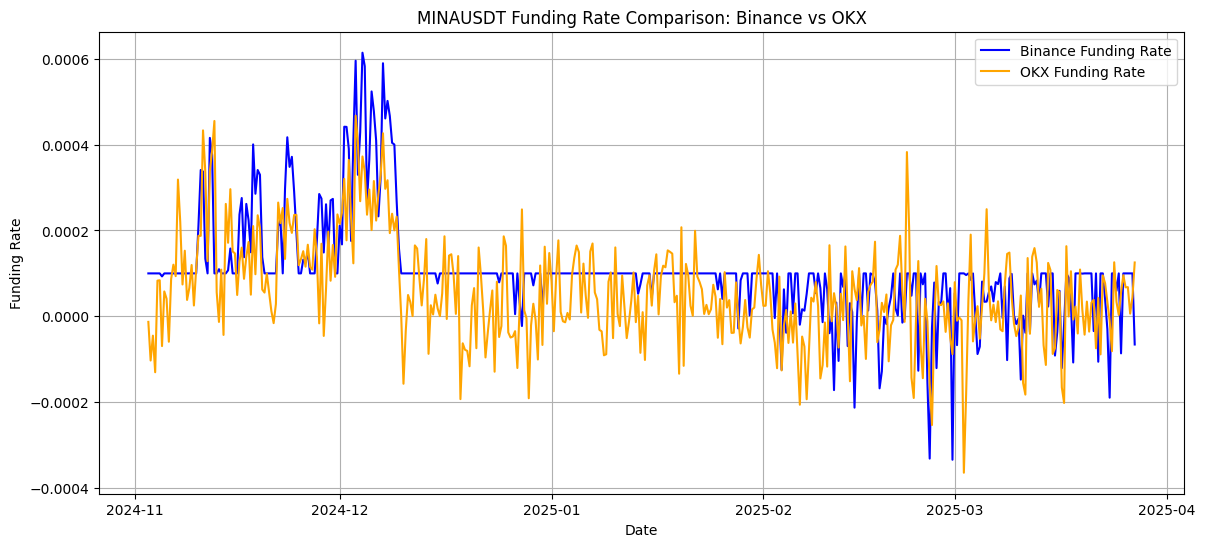

In [ ]:
merged_df = pd.read_csv("./funding rate/merged_funding_rate.csv", index_col = "fundingTime", parse_dates = True)
merged_df = merged_df[merged_df.index >= "2024-11-03"]
plt.figure(figsize = (14, 6))

plt.plot(merged_df.index, merged_df["Binance"], label = "Binance Funding Rate", color = "blue")
plt.plot(merged_df.index, merged_df["OKX"], label = "OKX Funding Rate", color = "orange")

plt.title("MINAUSDT Funding Rate Comparison: Binance vs OKX")
plt.xlabel("Date")
plt.ylabel("Funding Rate")
plt.legend()
plt.grid(True)
plt.show()

In [107]:
positive_count_B, negative_count_B = len(merged_df[merged_df["Binance"] > 0]), len(merged_df[merged_df["Binance"] < 0])
positive_count_OKX, negative_count_OKX = len(merged_df[merged_df["OKX"] > 0]), len(merged_df[merged_df["OKX"] < 0])

positive_percent_B, negative_percent_B = positive_count_B / len(merged_df) * 100, negative_count_B / len(merged_df) * 100
positive_percent_OKX, negative_percent_OKX = positive_count_OKX / len(merged_df) * 100, negative_count_OKX / len(merged_df) * 100

print(f"Binance: {positive_count_B} positive ({positive_percent_B:.2f}%), {negative_count_B} negative ({negative_percent_B:.2f}%)")
print(f"OKX: {positive_count_OKX} positive ({positive_percent_OKX:.2f}%), {negative_count_OKX} negative ({negative_percent_OKX:.2f}%)")

average_Binance, average_OKX = merged_df["Binance"].mean(), merged_df["OKX"].mean()
print(f"Average Funding Rate - Binance: {average_Binance:.7f}, OKX: {average_OKX:.7f}")

stat, p_value = levene(merged_df["Binance"], merged_df["OKX"])
print(f"Levene's test statistic: {stat:.4f}, p-value: {p_value:.4f}")
t_stat, p_value = ttest_ind(merged_df["Binance"], merged_df["OKX"], equal_var = False)
print(f"T-test statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

std_Binance = merged_df["Binance"].std()
std_OKX = merged_df["OKX"].std()
print(f"Standard Deviation Funding Rate - Binance: {std_Binance:.7f}, OKX: {std_OKX:.7f}")
print("SNR - Binance: {:.4f}, OKX: {:.4f}".format(average_Binance / std_Binance, average_OKX / std_OKX))

binance_pos_okx_neg = merged_df[(merged_df["Binance"] > 0) & (merged_df["OKX"] < 0)]
count_binance_pos_okx_neg = len(binance_pos_okx_neg)
percent_binance_pos_okx_neg = count_binance_pos_okx_neg / len(merged_df) * 100
print(f"Binance is positive & OKX is negative：{count_binance_pos_okx_neg} ，proportion：{percent_binance_pos_okx_neg:.2f}%")

okx_pos_binance_neg = merged_df[(merged_df["OKX"] > 0) & (merged_df["Binance"] < 0)]
count_okx_pos_binance_neg = len(okx_pos_binance_neg)
percent_okx_pos_binance_neg = count_okx_pos_binance_neg / len(merged_df) * 100
print(f"OKX is positive & Binance is negative：{count_okx_pos_binance_neg} ，proportion：{percent_okx_pos_binance_neg:.2f}%")

correlation = merged_df["Binance"].corr(merged_df["OKX"])
print(f"Correlation between funding rates: {correlation:.4f}")

Binance: 386 positive (88.94%), 48 negative (11.06%)
OKX: 296 positive (68.20%), 138 negative (31.80%)
Average Funding Rate - Binance: 0.0001036, OKX: 0.0000575
Levene's test statistic: 29.0812, p-value: 0.0000
T-test statistic: 5.6856, p-value: 0.0000
Standard Deviation Funding Rate - Binance: 0.0001177, OKX: 0.0001211
SNR - Binance: 0.8798, OKX: 0.4749
Binance is positive & OKX is negative：112 ，proportion：25.81%
OKX is positive & Binance is negative：22 ，proportion：5.07%
Correlation between funding rates: 0.5630


Binance 的資料從API抓取，從2023-02-03 ~ 2025-03-27  
OKX 的資料原本從API抓，但後來發現只有最近三個月，故改以爬蟲抓歷史資料庫的資料，也是從2023-02-03 ~ 2025-03-27  
但後來發現用全部資料看不出圖，所以只截取最近三個月資料做觀察  

Binance 的資料是8小時一次，OKX 由 2024-07-25 開始，資料從8小時一次改成4小時，故將其 resample 成8小時  
最後資料使用為：2024-11-03 00:00 ~ 2025-03-27 08:00  

funding rate 代表現貨跟合約之間的關係，當合約高於現貨，合約買方要支付 funding rate 給賣方（funding rate > 0）；當合約低於現貨，賣方要支付 funding rate 給買方（funding rate < 0）  
無論是 Binance 或 OKX，可以看到這段期間普遍為 long 方更強，但兩家交易所相較而言，Binance 有更強且顯著的買壓  
從標準差可以看出，Binance 的 funding rate 波動較小，又從 SNR 可以看出相較 OKX 而言，Binance 穩定為正  
這段時間內有 26% 是 Binance 為正時，OKX 為負，表示兩間交易所的用戶屬性差距很大  
但相關係數為 0.6，表示兩家交易所的 funding rate 仍有一定的正向關係